# Self made RP3-beta

In [0]:
pip install surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675402 sha256=0402e186e04cc281f74955fc53a5f90361c98d08599a8e72cc36eb0b55dafd8a
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [0]:
class RP3Beta():
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui=train_ui
        self.train_iu=train_ui.transpose()
        
        self.alpha = alpha
        self.beta = beta
        
        # Define Pui 
        Pui=sparse.csr_matrix(self.train_ui/self.train_ui.sum(axis=1))
        
        # Define Piu
        to_divide=np.vectorize(lambda x: x if x>0 else 1)(self.train_iu.sum(axis=1)) # to avoid dividing by zero
        Piu=sparse.csr_matrix(self.train_iu/to_divide)
        item_orders=(self.train_ui>0).sum(axis=0)
        
        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3=Pui*Piu*Pui
        
        P3/=np.power(np.vectorize(lambda x: x if x>0 else 1)(item_orders), self.beta)
        
        self.estimations=np.array(P3)
    
    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [0]:
model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [0]:
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_P3_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', index=False, header=False)

In [0]:
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 6376.09it/s]


RMSE       MAE  precision  ...  Test coverage   Shannon      Gini
0  3.702446  3.527273   0.282185  ...       0.077201  3.875892  0.974947

[1 rows x 17 columns]

# Let's check hiperparameters

##### Alpha

In [0]:
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 6334.35it/s]
 12%|█▎        | 1/8 [00:11<01:19, 11.38s/it]
0it [00:00, ?it/s]
943it [00:00, 6365.04it/s]
 25%|██▌       | 2/8 [00:22<01:07, 11.33s/it]
0it [00:00, ?it/s]
943it [00:00, 6323.80it/s]
 38%|███▊      | 3/8 [00:34<00:56, 11.37s/it]
0it [00:00, ?it/s]
943it [00:00, 6484.87it/s]
 50%|█████     | 4/8 [00:45<00:45, 11.32s/it]
0it [00:00, ?it/s]
943it [00:00, 6172.18it/s]
 62%|██████▎   | 5/8 [00:56<00:33, 11.27s/it]
0it [00:00, ?it/s]
943it [00:00, 6405.62it/s]
 75%|███████▌  | 6/8 [01:07<00:22, 11.32s/it]
0it [00:00, ?it/s]
943it [00:00, 6547.37it/s]
 88%|████████▊ | 7/8 [01:19<00:11, 11.35s/it]
0it [00:00, ?it/s]
943it [00:00, 6573.96it/s]
100%|██████████| 8/8 [01:30<00:00, 11.31s/it]


Alpha        RMSE         MAE  ...  Test coverage   Shannon      Gini
0    0.2  268.177832  211.732649  ...       0.060606  3.669627  0.979636
0    0.4   10.546689    7.792373  ...       0.064214  3.726996  0.978426
0    0.6    3.143988    2.948790  ...       0.065657  3.785282  0.977090
0    0.8    3.670728    3.495735  ...       0.070707  3.832415  0.975998
0    1.0    3.702446    3.527273  ...       0.077201  3.875892  0.974947
0    1.2    3.704441    3.529251  ...       0.085859  3.910718  0.974073
0    1.4    3.704580    3.529388  ...       0.107504  3.961915  0.972674
0    1.6    3.704591    3.529399  ...       0.156566  4.060156  0.969203

[8 rows x 18 columns]

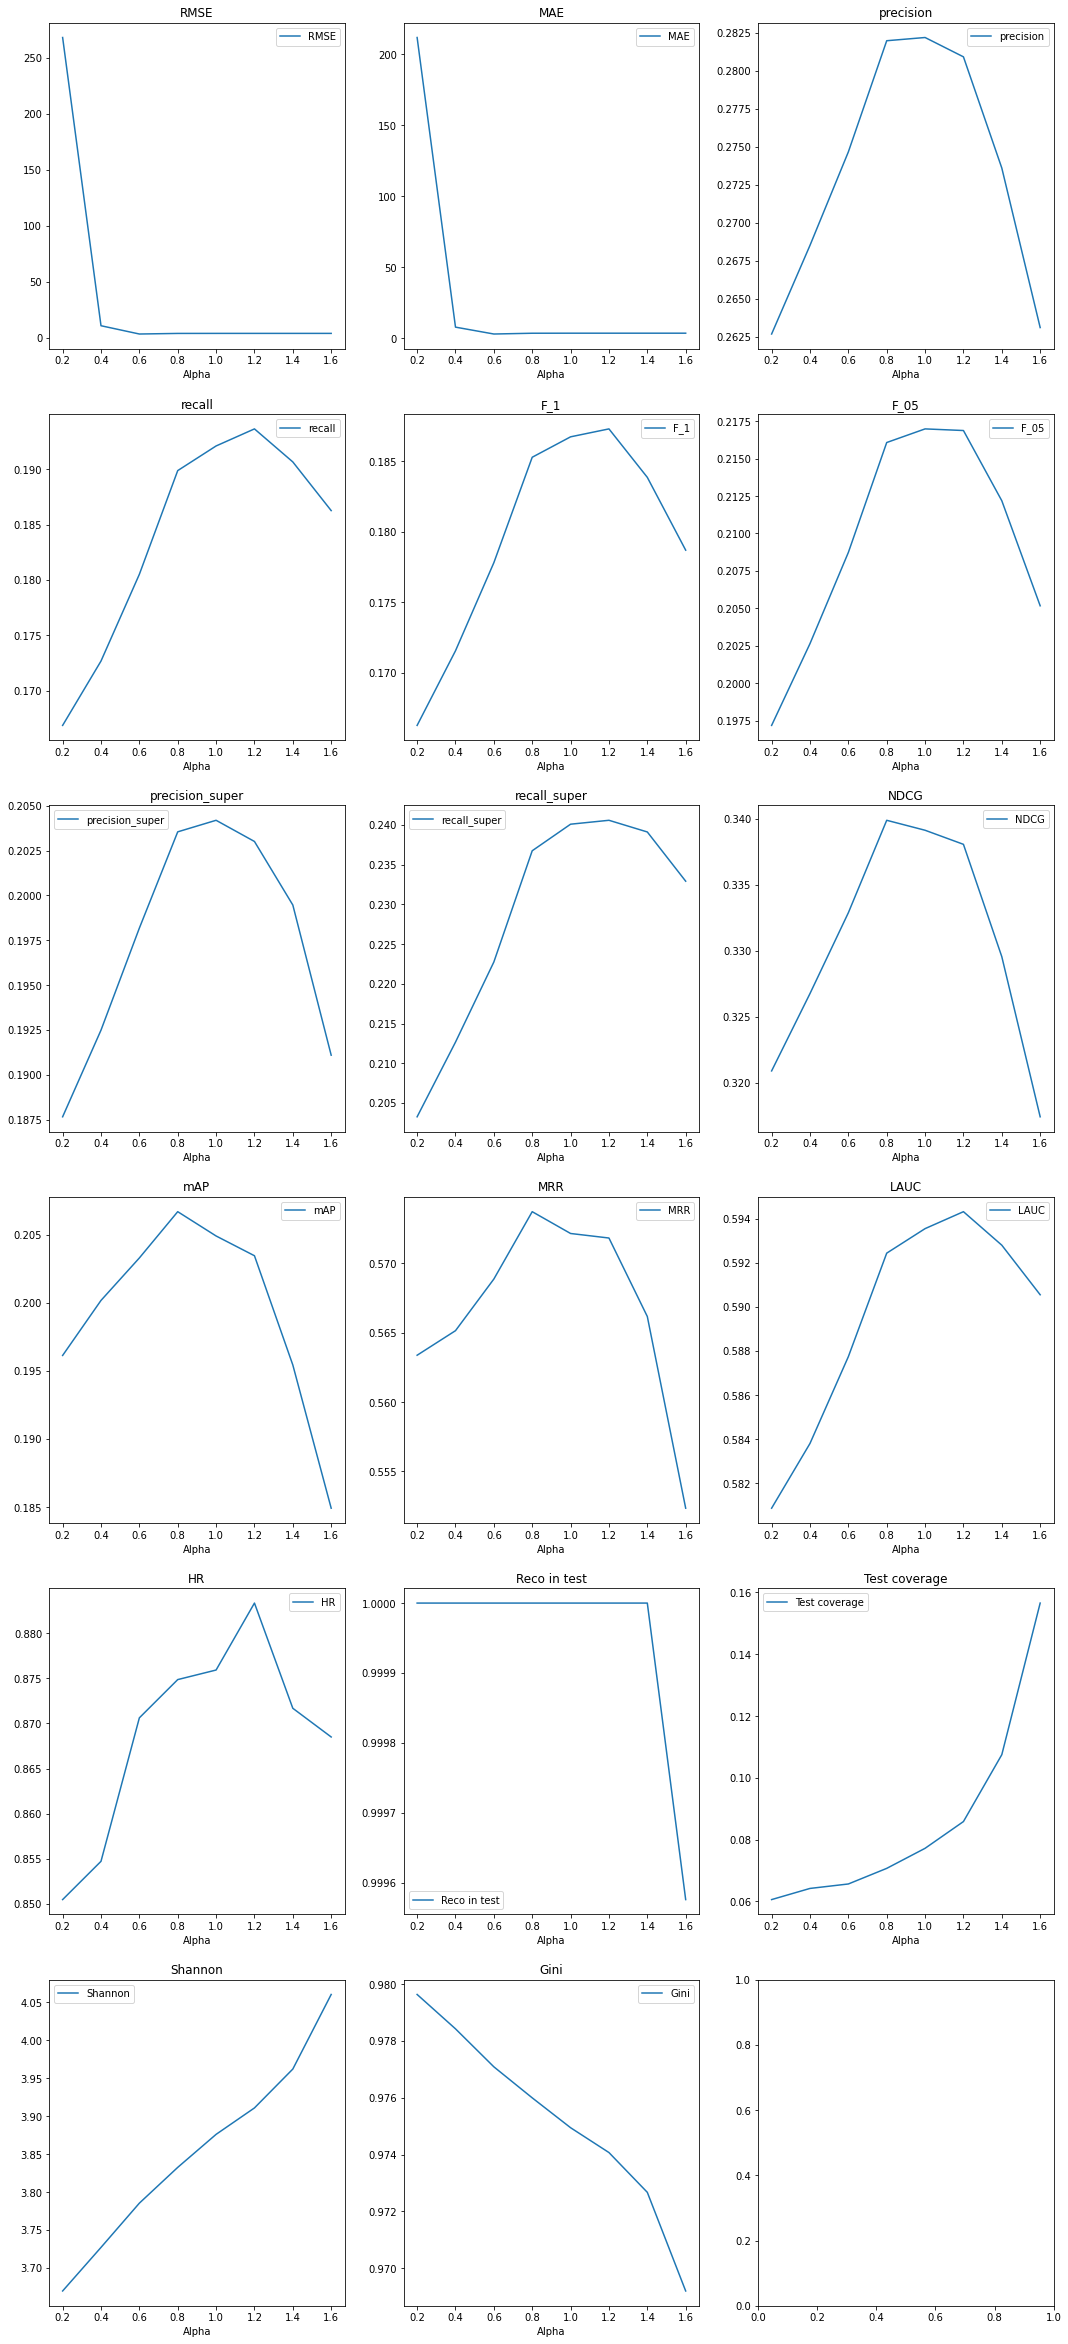

In [0]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [0]:
from tqdm import tqdm
result=[]
for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Beta", beta)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 6498.11it/s]
 10%|█         | 1/10 [00:11<01:44, 11.61s/it]
0it [00:00, ?it/s]
943it [00:00, 6408.36it/s]
 20%|██        | 2/10 [00:23<01:32, 11.61s/it]
0it [00:00, ?it/s]
943it [00:00, 6396.07it/s]
 30%|███       | 3/10 [00:34<01:20, 11.54s/it]
0it [00:00, ?it/s]
943it [00:00, 5925.94it/s]
 40%|████      | 4/10 [00:46<01:09, 11.58s/it]
0it [00:00, ?it/s]
943it [00:00, 5799.00it/s]
 50%|█████     | 5/10 [00:57<00:57, 11.46s/it]
0it [00:00, ?it/s]
943it [00:00, 6089.68it/s]
 60%|██████    | 6/10 [01:08<00:45, 11.37s/it]
0it [00:00, ?it/s]
943it [00:00, 5271.79it/s]
 70%|███████   | 7/10 [01:20<00:34, 11.43s/it]
0it [00:00, ?it/s]
943it [00:00, 6396.94it/s]
 80%|████████  | 8/10 [01:31<00:22, 11.32s/it]
0it [00:00, ?it/s]
943it [00:00, 6464.53it/s]
 90%|█████████ | 9/10 [01:42<00:11, 11.29s/it]
0it [00:00, ?it/s]
943it [00:00, 6338.37it/s]
100%|██████████| 10/10 [01:53<00:00, 11.38s/it]


Beta      RMSE       MAE  ...  Test coverage   Shannon      Gini
0   0.0  3.702446  3.527273  ...       0.077201  3.875892  0.974947
0   0.1  3.703312  3.528128  ...       0.085137  3.957416  0.972784
0   0.2  3.703825  3.528636  ...       0.094517  4.053212  0.969980
0   0.3  3.704130  3.528939  ...       0.105339  4.147779  0.966948
0   0.4  3.704313  3.529120  ...       0.132035  4.259682  0.962989
0   0.5  3.704422  3.529229  ...       0.168831  4.411281  0.956648
0   0.6  3.704488  3.529295  ...       0.212843  4.621938  0.945932
0   0.7  3.704528  3.529335  ...       0.256854  4.898568  0.928065
0   0.8  3.704552  3.529360  ...       0.341270  5.257397  0.895882
0   0.9  3.704567  3.529375  ...       0.415584  5.563910  0.857396

[10 rows x 18 columns]

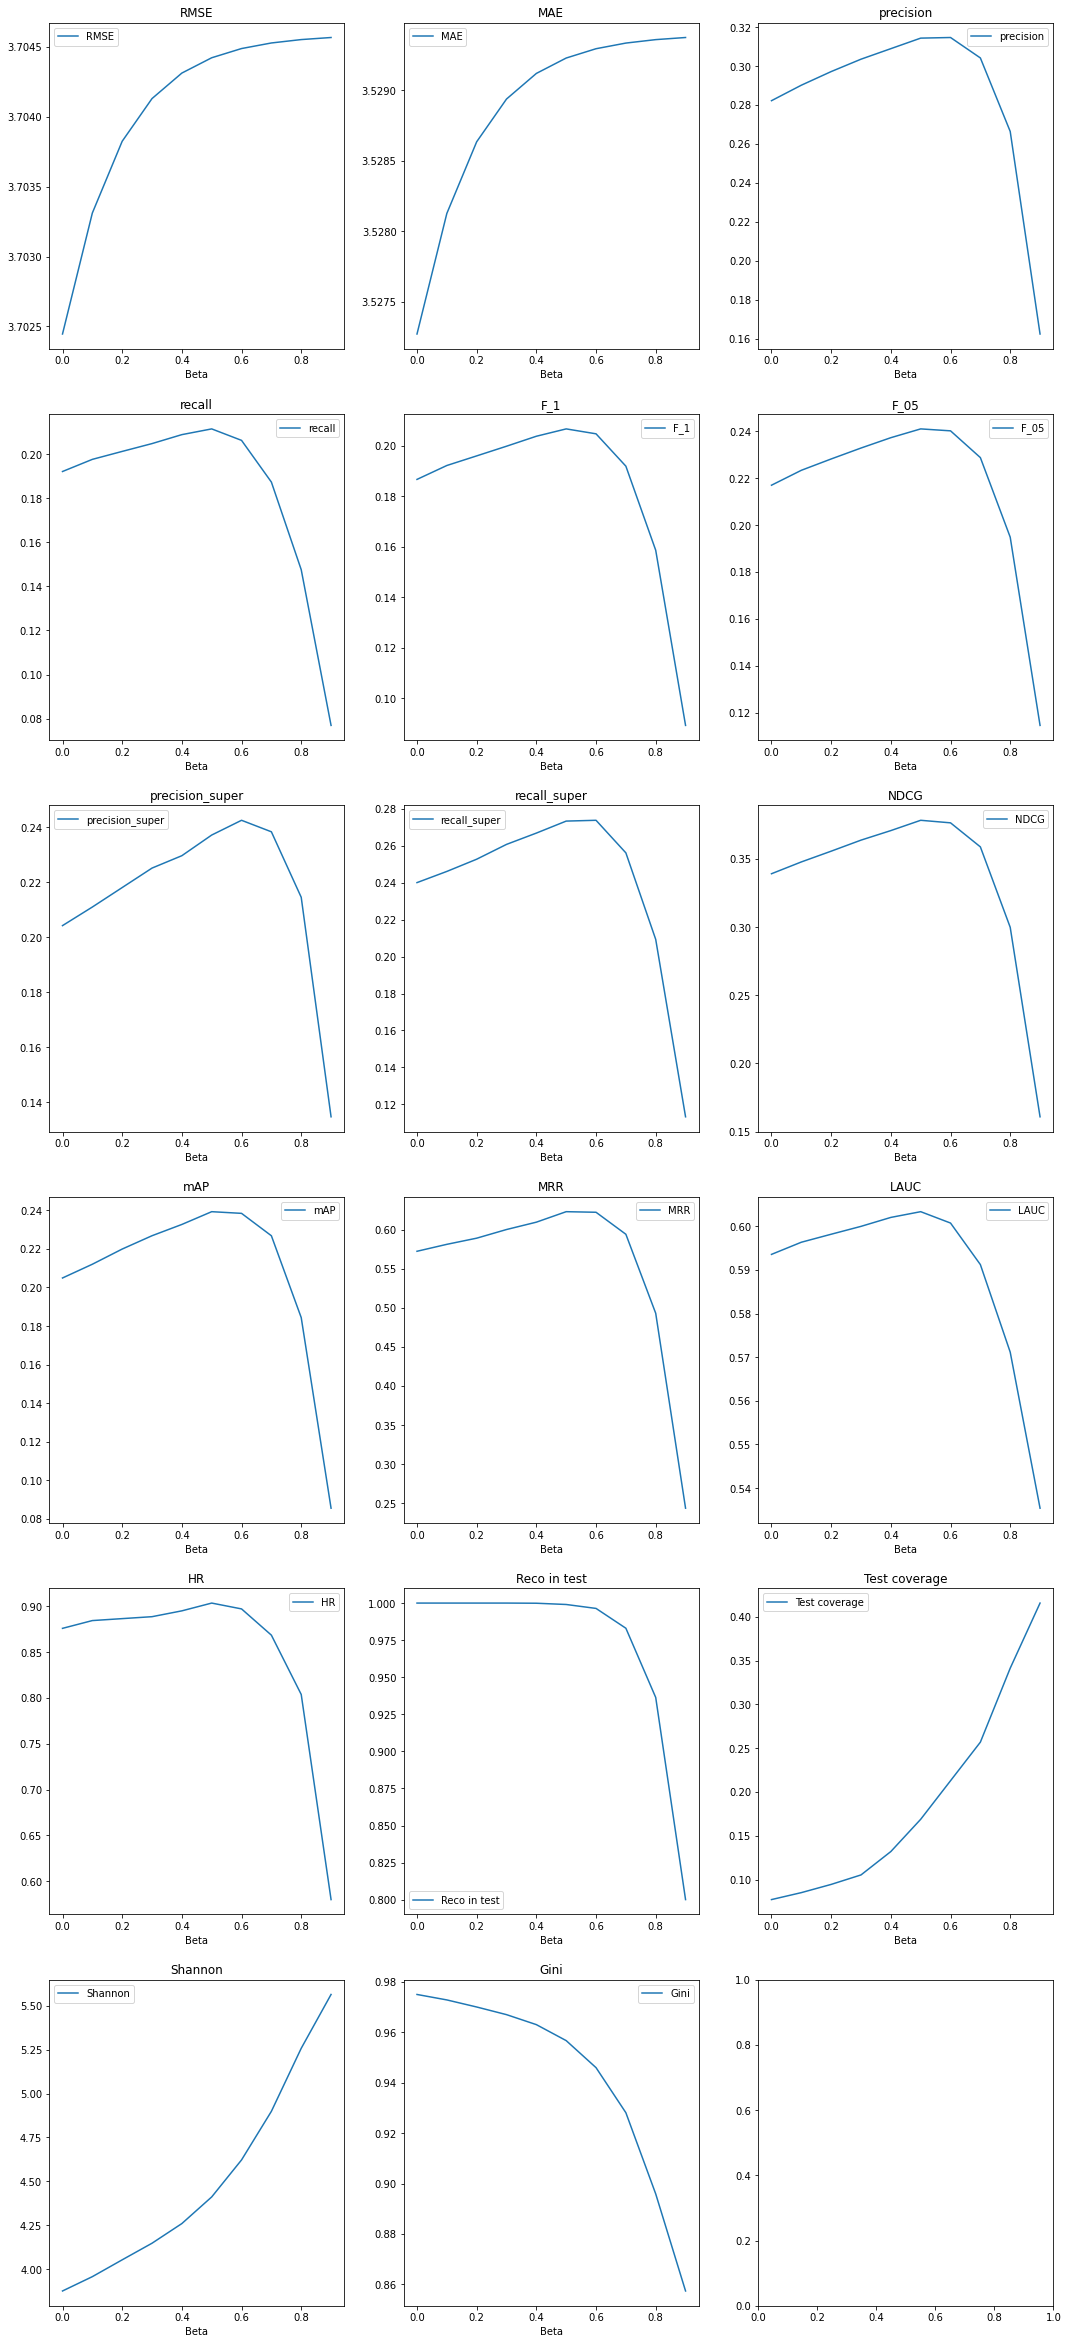

In [0]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Beta'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Beta', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [0]:
train=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

user=random.choice(list(set(train['user'])))

train_content=pd.merge(train, items, left_on='item', right_on='id')
display(train_content[train_content['user']==user][['user', 'rating', 'title', 'genres']]\
        .sort_values(by='rating', ascending=False)[:15])

reco = np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

# Let's ignore scores - they are not used in evaluation: 
reco_users=reco[:,:1]
reco_items=reco[:,1::2]
# Let's put them into one array
reco=np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended=[]
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb+1, entry))
recommended=pd.DataFrame(recommended, columns=['user','rec_nb', 'item'])

recommended_content=pd.merge(recommended, items, left_on='item', right_on='id')
recommended_content[recommended_content['user']==user][['user', 'rec_nb', 'title', 'genres']].sort_values(by='rec_nb')

user  ...                               genres
10631   190  ...                           Drama, War
19196   190  ...                     Horror, Thriller
5262    190  ...                       Drama, Romance
46114   190  ...  Crime, Film-Noir, Mystery, Thriller
40446   190  ...               Action, Drama, Romance
45123   190  ...            Action, Romance, Thriller
33331   190  ...                    Mystery, Thriller
34493   190  ...         Action, Drama, Thriller, War
39439   190  ...                         Crime, Drama
40264   190  ...                                Drama
461     190  ...              Action, Crime, Thriller
30171   190  ...            Action, Adventure, Sci-Fi
47145   190  ...                      Drama, Thriller
55123   190  ...                     Action, Thriller
58856   190  ...                      Comedy, Romance

[15 rows x 4 columns]

user  ...                                   genres
84    190.0  ...  Action, Adventure, Romance, Sci-Fi, War
1019  190.0  ...                      Drama, Romance, War
2704  190.0  ...  Action, Adventure, Romance, Sci-Fi, War
3106  190.0  ...            Animation, Children's, Comedy
3611  190.0  ...       Action, Mystery, Romance, Thriller
2268  190.0  ...                     Action, Crime, Drama
8825  190.0  ...        Action, Adventure, Comedy, Sci-Fi
6263  190.0  ...                                    Drama
8307  190.0  ...                           Drama, Romance
4369  190.0  ...                                    Drama

[10 rows x 4 columns]

# project task 6: generate recommendations of RP3Beta for hiperparameters found to optimize recall

In [0]:
# use better values than (1,0) for alpha and beta
# if you want you can also modify the model to consider different weights (we took as weights user ratings, maybe take ones or squares of ratings instead)
# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

import evaluation_measures as ev

model=RP3Beta()
model.fit(train_ui, alpha=0.6, beta=0.4)  # wartości alpha 0.6, beta 0.4 mają mniejszy RMSE, MAE, większą precyzję i niedużo większy recall
model_reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
model_reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 7119.46it/s]


RMSE       MAE  precision  ...  Test coverage   Shannon      Gini
0  3.626913  3.450842   0.309862  ...       0.105339  4.209113  0.964697

[1 rows x 17 columns]

In [0]:
import evaluation_measures as ev

model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)    # alpha, 1 beta 0
model_reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
model_reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco2.csv', index=False, header=False)
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations2.csv', index=False, header=False)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco2.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 6878.29it/s]


RMSE       MAE  precision  ...  Test coverage   Shannon      Gini
0  3.702446  3.527273   0.282185  ...       0.077201  3.875892  0.974947

[1 rows x 17 columns]

# project task 7 (optional): implement graph-based model of your choice 

In [0]:
# for example change length of paths in RP3beta
# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'